<center><h1>Evaluate LLMs Using FLASK Benchmarks</h1></center>

In [1]:
#%pip install -q guidance

In [2]:
## Update GOOGLE_APPLICATION_CREDENTIALS and OPEN_API_KEY with your values

In [3]:
import os
import vertexai
from ast import literal_eval
from langchain.llms import VertexAI
from guidance import models, gen, system, user, assistant

import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from collections import defaultdict

In [4]:
# Update GOOGLE_APPLICATION_CREDENTIALS and OPEN_API_KEY with your values
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="" 
os.environ["OPENAI_API_KEY"] = "" #update with your value

PROJECT_ID = "" # use your project id
REGION = "us-central1"  #
BUCKET_URI = f""  # use your bucket

vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [5]:
def get_responses(model_1, model_2):
    # Choose prompts for evaluation
    prompt_1 = "What are the key factors to consider when starting a new business?" # @param {type:"string"}
    prompt_2 = "What are the most common mistakes startups make and how can they be avoided?" # @param {type:"string"}
    prompt_3 = "What are the best strategies for raising initial capital for a startup?" # @param {type:"string"}
    prompt_4 = "How can a startup effectively validate its business idea?" # @param {type:"string"}
    prompt_5 = "What are the best practices for managing cash flow in a startup?" # @param {type:"string"}
    prompt_6 = "How can a startup create a strong and sustainable company culture?" # @param {type:"string"}
    prompt_7 = "What are the key metrics a startup should track and why?" # @param {type:"string"}
    prompt_8 = "How can a startup effectively market its product or service?" # @param {type:"string"}
    prompt_9 = "What are the best strategies for a startup to handle competition?" # @param {type:"string"}
    prompt_10 = "How can a startup maintain its focus and avoid distractions?" # @param {type:"string"}

    prompts = [
        prompt_1,
        prompt_2,
        prompt_3,
        prompt_4,
        prompt_5,
        prompt_6,
        prompt_7,
        prompt_8,
        prompt_9,
        prompt_10
        ]


    system_prompt = "Provide a comprehensive and detailed response that includes innovative insights and clear, structured explanations. Focus on delivering practical, actionable advice. Ensure relevance to the startup and tech industry, emphasizing current trends and future possibilities. Be specific in your examples and explanations, and consider adding unique perspectives or novel approaches to standard practices. Aim for clarity in communication, organizing your response logically and coherently.\n"

    responses = []
    for prompt in prompts:
        # gemini_response = llm_gemini_pro(system_prompt + prompt)
        model_1_response = model_1(system_prompt + prompt)
        model_2_response = model_2(system_prompt + prompt)
        responses.append((model_1_response , model_2_response))
    
    return responses

In [6]:
def guidance_helper(system_prompt, model, prompt, output_key, max_tokens=1500):
    mdl = model
    with system():
        mdl += system_prompt
    with user():
        mdl += prompt
    with assistant():
        mdl += gen(name=output_key, max_tokens=max_tokens)
    return mdl[output_key]

In [7]:
def get_scores(responses, model_1_name, model_2_name):
    # Score each model response
    system_prompt = """You are to evaluate each response on the likert scale (1-5) for dimensions including:
    Robustness
    Correctness
    Efficiency
    Factuality
    Commonsense
    Comprehension
    Insightfulness
    Completeness
    Metacognition
    Readability
    Conciseness
    Harmlessness

    Make sure to structure your responses as JSON.
    """
    scores = []
    for response in responses:
        score = guidance_helper(system_prompt, models.OpenAI("gpt-4"), f"{model_1_name}:\n" + f"\n\n{model_2_name}:\n".join(response), "scores", 2000)
        scores.append(score)
    
    return scores

In [8]:
llm_gemini_pro = VertexAI(model_name="gemini-pro")
llm_text_bison_1 =  VertexAI(model_name="text-bison@001")
llm_text_bison_2 =  VertexAI(model_name="text-bison@002")

c:\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.vertexai.VertexAI` was deprecated in langchain-community 0.0.12 and will be removed in 0.2.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import VertexAI`.
  warn_deprecated(


In [9]:
def get_dataframe(scores, model_1_name, model_2_name):
    # Data
    avg_data = [literal_eval(score) for score in scores]
    average_data = defaultdict(lambda: defaultdict(list))

    # Accumulate the values for each model and attribute
    for entry in avg_data:
        for model, attributes in entry.items():
            if isinstance(attributes, dict):
                for attribute, value in attributes.items():
                    average_data[model][attribute].append(value)


    # Calculate the averages
    for model, attributes in average_data.items():
        for attribute, values in attributes.items():
            average_data[model][attribute] = sum(values) / len(values)


    # Convert defaultdict to regular dict for display
    average_data_dict = {model: dict(attributes) for model, attributes in average_data.items()}
    average_data_dict = {key: average_data_dict[key] for key in [model_1_name, model_2_name]}

    # Convert to DataFrame
    df = pd.DataFrame(average_data_dict)
    
    return df

In [19]:
def plot_assessment_scores(df):
    # Number of variables/categories
    categories = list(df.index)
    N = len(categories)

    # What will be the angle of each axis in the plot?
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the loop

    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, fontsize=12, fontweight='bold')

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=7, fontsize=12, fontweight='bold')
    plt.ylim(0,5)

    # Plot data for each model
    for model in df.columns:
        values = list(df[model]) + list(df[model])[:1]  # Complete the loop for plotting
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title('Fine-Grained Skills Assessment\n', fontsize=25)

    # Show the plot
    plt.show()

In [11]:
model_1_name = "gemini-pro"
model_2_name = "text-bison@001"
model_3_name = "text-bison@002"

model_1= VertexAI(model_name = model_1_name)
model_2 =  VertexAI(model_name = model_2_name)
model_3 =  VertexAI(model_name = model_3_name)

In [12]:
# Generate Scores DataFrame for Models 1 and 2
responses_1 = get_responses(model_1, model_2)
scores_1 = get_scores(responses_1, model_1_name, model_2_name)
df_1 = get_dataframe(scores_1, model_1_name, model_2_name)

In [13]:
# Generate Scores DataFrame for Models 1 and 2
responses_2 = get_responses(model_1, model_3)
scores_2 = get_scores(responses_2, model_1_name, model_3_name)
df_2 = get_dataframe(scores_2, model_1_name, model_3_name)

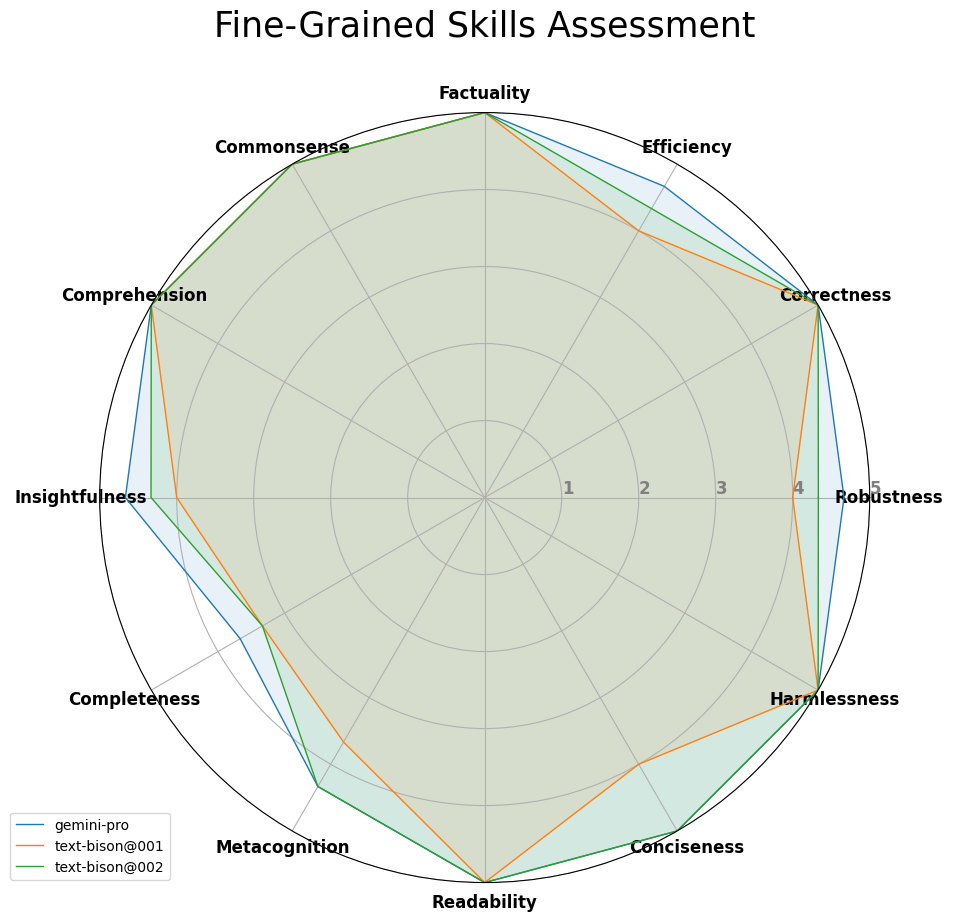

In [24]:
# Merge Dataframes 1 and 2 to display in unified plot
df_1[model_3_name]=df_2[model_3_name]
plot_assessment_scores(df_1)